In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import rfft, rfftfreq 
from scipy import signal
from scipy.fft import fftshift

In [62]:
df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Stable.csv", sep=",")
#df = pd.read_csv("C:/Users/JackC/Documents/TU Delft/BAP/Measurements/Physcial clincing right forearm.csv", sep=",")
end = 750
fs = 250
df = df.iloc[:end, :8] # 3000 samples is 12 seconds of data
df

,EEG 1,EEG 2,EEG 3,EEG 4,EEG 5,EEG 6,EEG 7,EEG 8
0,-8.915,-10.059,-7.009,-14.081,-9.280,-11.682,-11.592,-7.524
1,-5.324,-8.059,-4.722,-11.473,-7.158,-10.473,-11.065,-6.499
2,-0.852,-3.834,-1.164,-7.041,-3.071,-6.358,-7.496,-3.079
3,2.978,0.699,2.066,-2.508,1.126,-1.363,-2.966,0.973
4,5.052,3.670,3.729,0.674,3.850,2.389,0.530,3.997
...,...,...,...,...,...,...,...,...
745,7.060,32.242,10.357,2.576,12.793,9.910,14.099,6.934
746,10.047,29.498,11.522,5.046,13.700,10.647,14.623,8.358
747,12.709,26.015,12.625,7.627,14.361,11.300,15.302,9.760
748,13.464,20.799,12.063,8.684,13.235,10.520,14.493,9.850


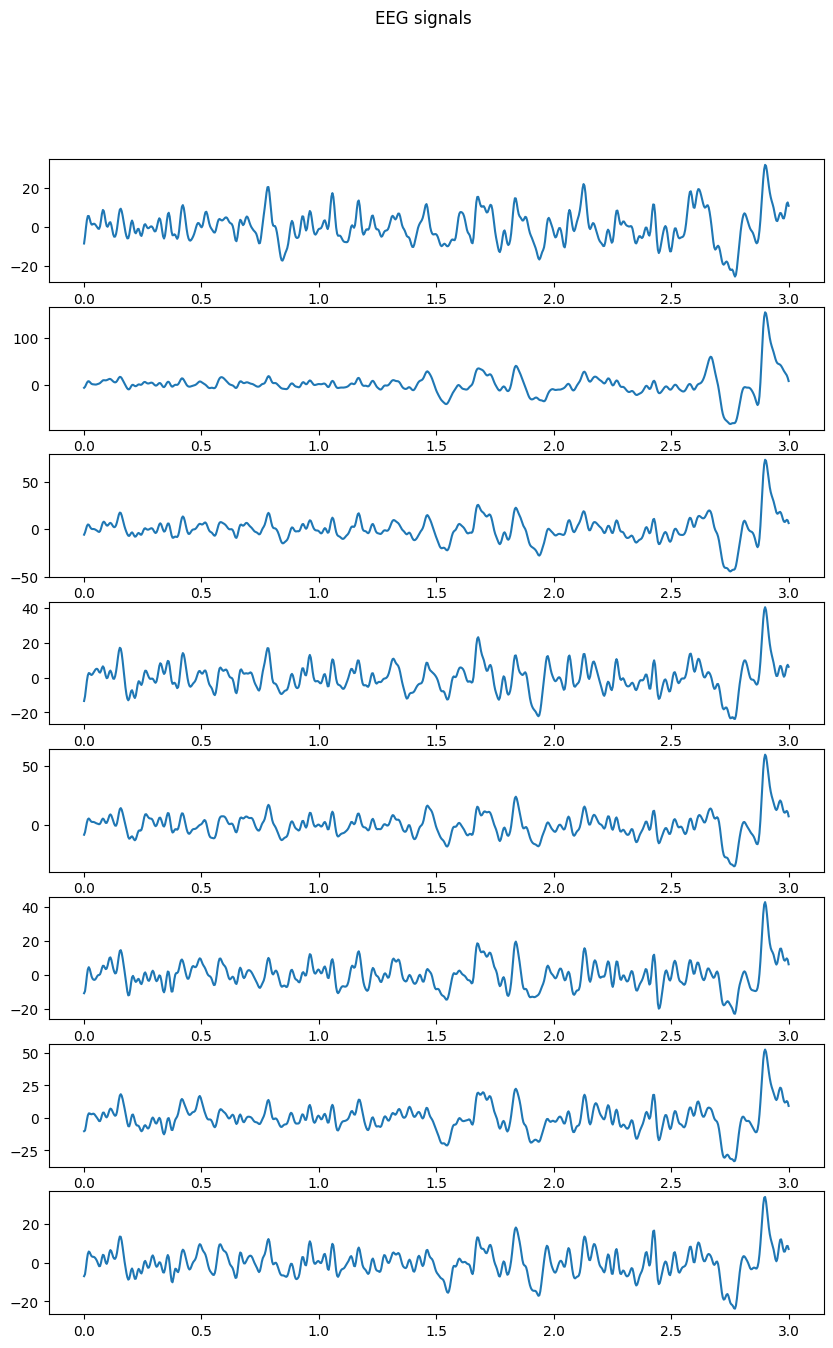

In [63]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

# Remove the DC component
df = signal.detrend(df, axis=0)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,df[:,i])


In [64]:
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal

# Define the filter parameters
lowcut = 2
highcut = 30
fs = 250  # Sampling frequency

# Calculate the filter coefficients
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter(8, [low, high], btype='band')

# Apply the filter to each column of the DataFrame
df_filt = lfilter(b, a, df, axis = 0)

# import scipy.signal as signal

# Define the notch filter parameters
fs = 250  # Sampling frequency
f0 = 50  # Notch frequency
Q = 1 # Quality factor

# Design the notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Apply the filter to each column of the DataFrame
df_filt1 = lfilter(b, a, df_filt)

In [65]:
# Remove the DC component
#df_filt1 = signal.detrend(df_filt1, axis = 0)

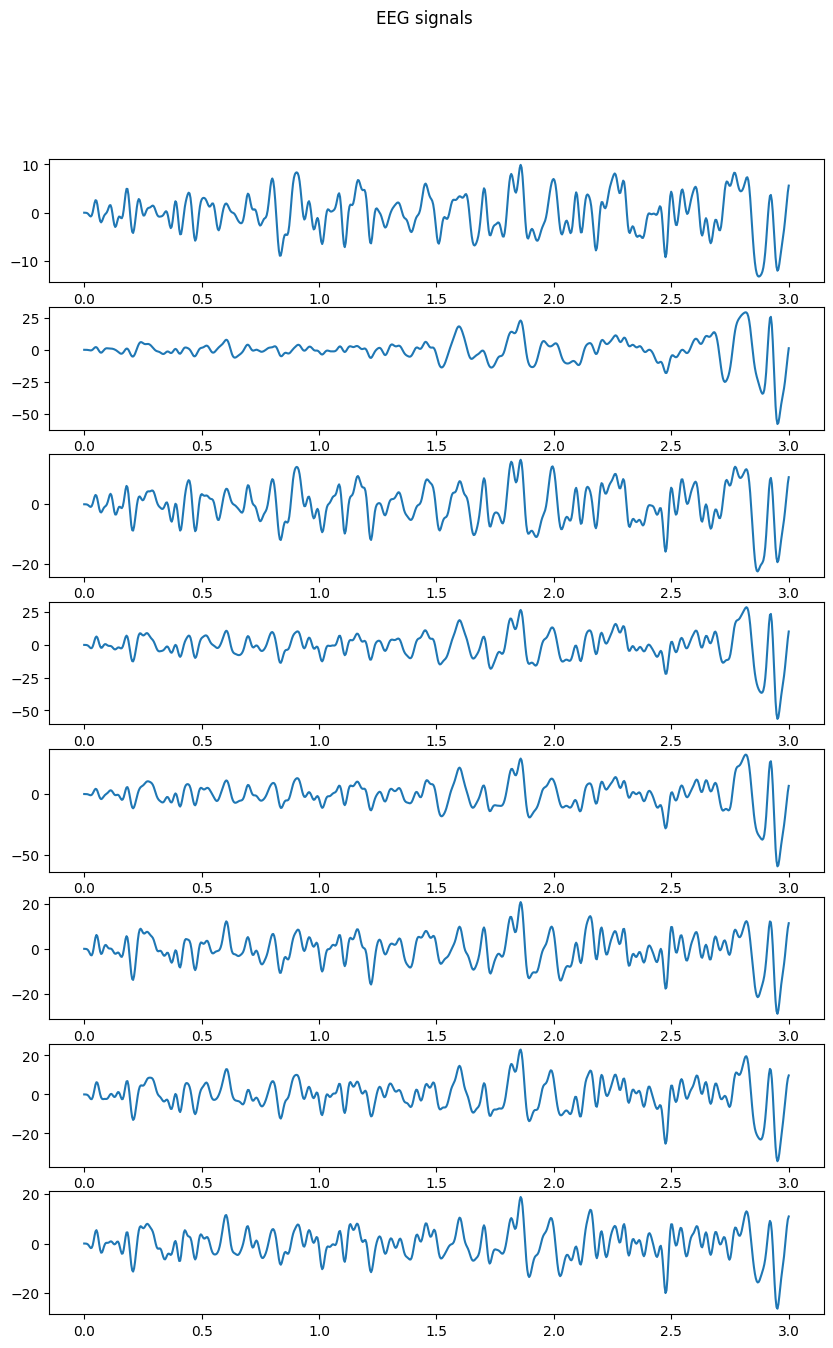

In [66]:
x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,df_filt1[:,i])

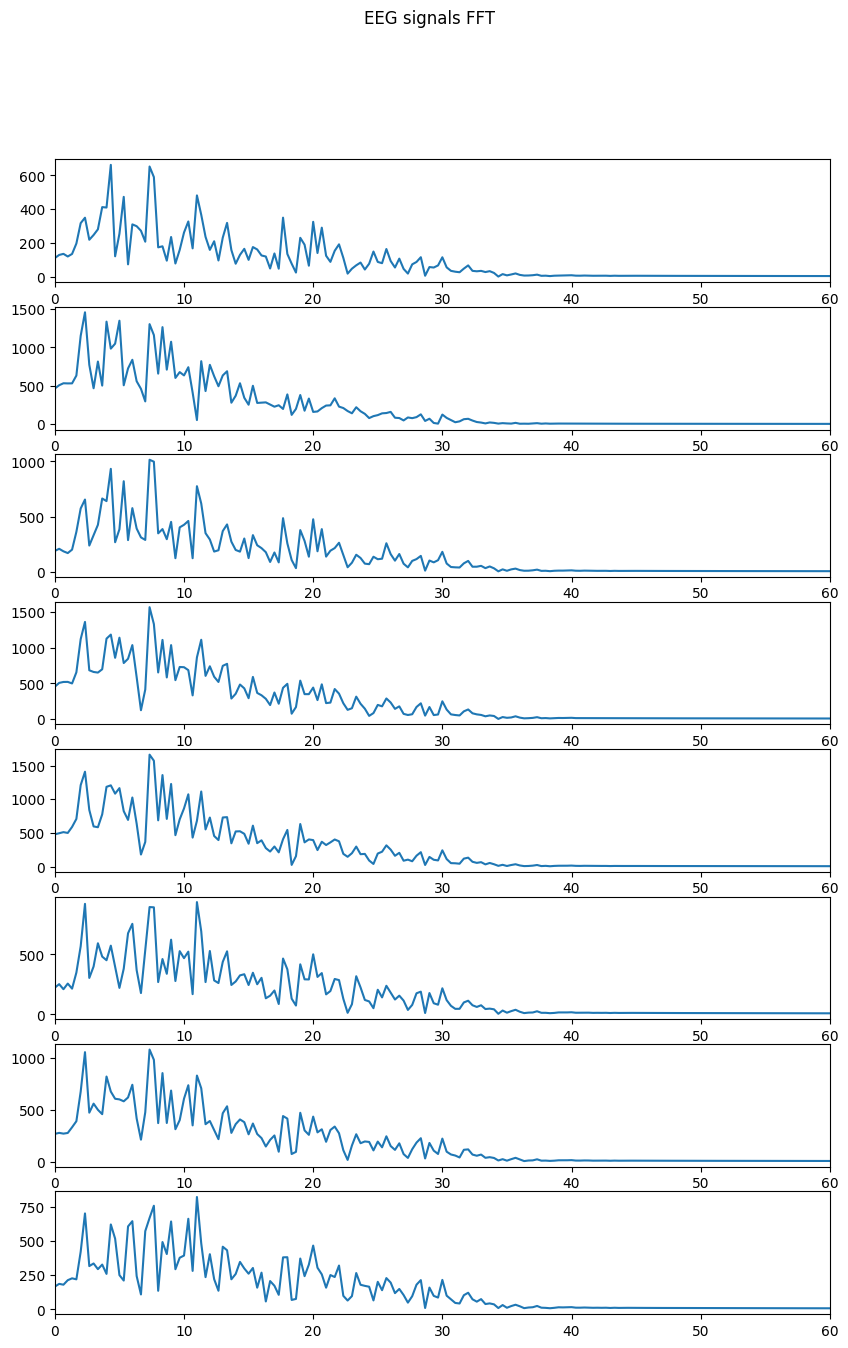

In [67]:
xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals FFT')
for i in range(8):
    yf = rfft(df_filt1[:,i])
    axs[i].plot(xf, np.abs(yf))
    axs[i].set_xlim([0, 60])
    # Setting the number of ticks 
    axs[i].locator_params(axis='x', nbins=10)
    

C:\Users\JackC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 1024 is greater than input length  = 750, using nperseg = 750
  warnings.warn('nperseg = {0:d} is greater than input length '


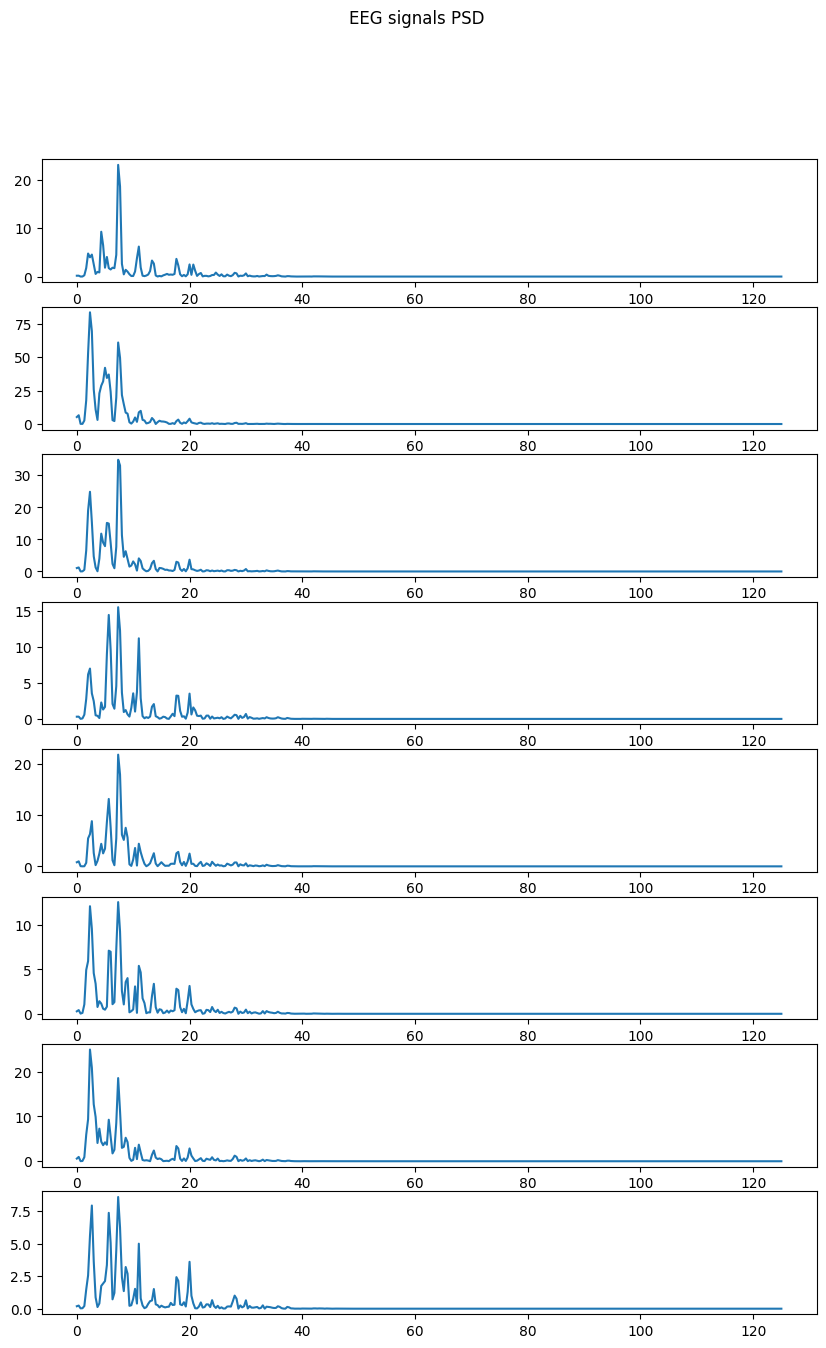

In [68]:
from scipy import signal

xf = rfftfreq(end, 1 / fs)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals PSD')
for i in range(8):
    # Compute the power spectral density
    frequencies, power_density = signal.welch(df[:,i], fs, nperseg=1024, scaling='density')


    # Plot the power spectral density
    axs[i].plot(frequencies, power_density)
    #plt.psd(df[:,i], Fs = 250)
    #axs[i].xlabel('Frequency (Hz)')
    #axs[i].ylabel('Power Spectral Density')
    #axs[i].title('Power Spectral Density Plot')


